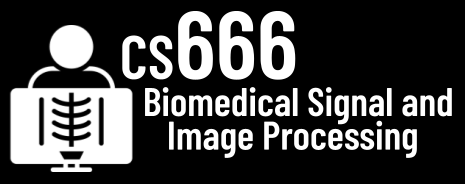
# Assignment 6

In [ ]:
# NAME: Poornendu Pabbati

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0. Data loading (5 points)

In [ ]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

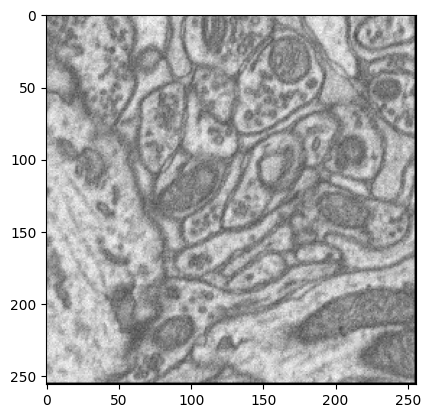

In [ ]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
import matplotlib.pyplot as plt
plt.imshow(images[0], cmap='gray')
plt.show()

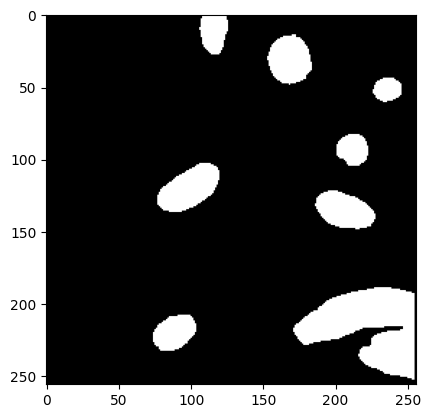

In [ ]:
# TODO: Show the first mask.
plt.imshow(masks[0], cmap='gray')
plt.show()

## 1. SAM in AUTO mode (15 points)

In [ ]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [ ]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [ ]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


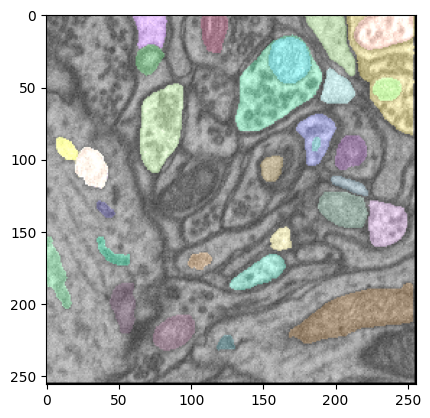

In [ ]:
imshow( mh.imread('first_output.png') )

In [ ]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: The Segment Anything model works well to an extent for mitochondria detection 

In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

In [ ]:
# TODO: YOUR CODE
mh.imsave('test.png',images[100])

In [ ]:
results2 = SegAutoMaskPredictor().image_predict(
    source="test.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


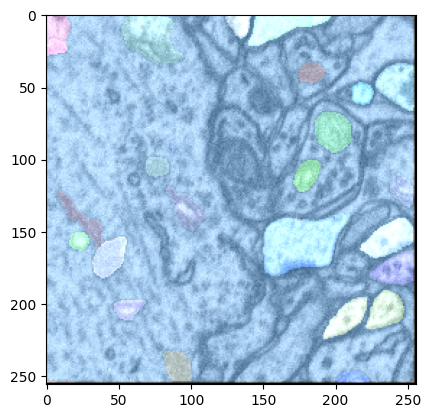

In [ ]:
imshow( mh.imread('second_output.png') )

In [ ]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

## 2. Train a U-Net classifier from scratch (50 points)


In [ ]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


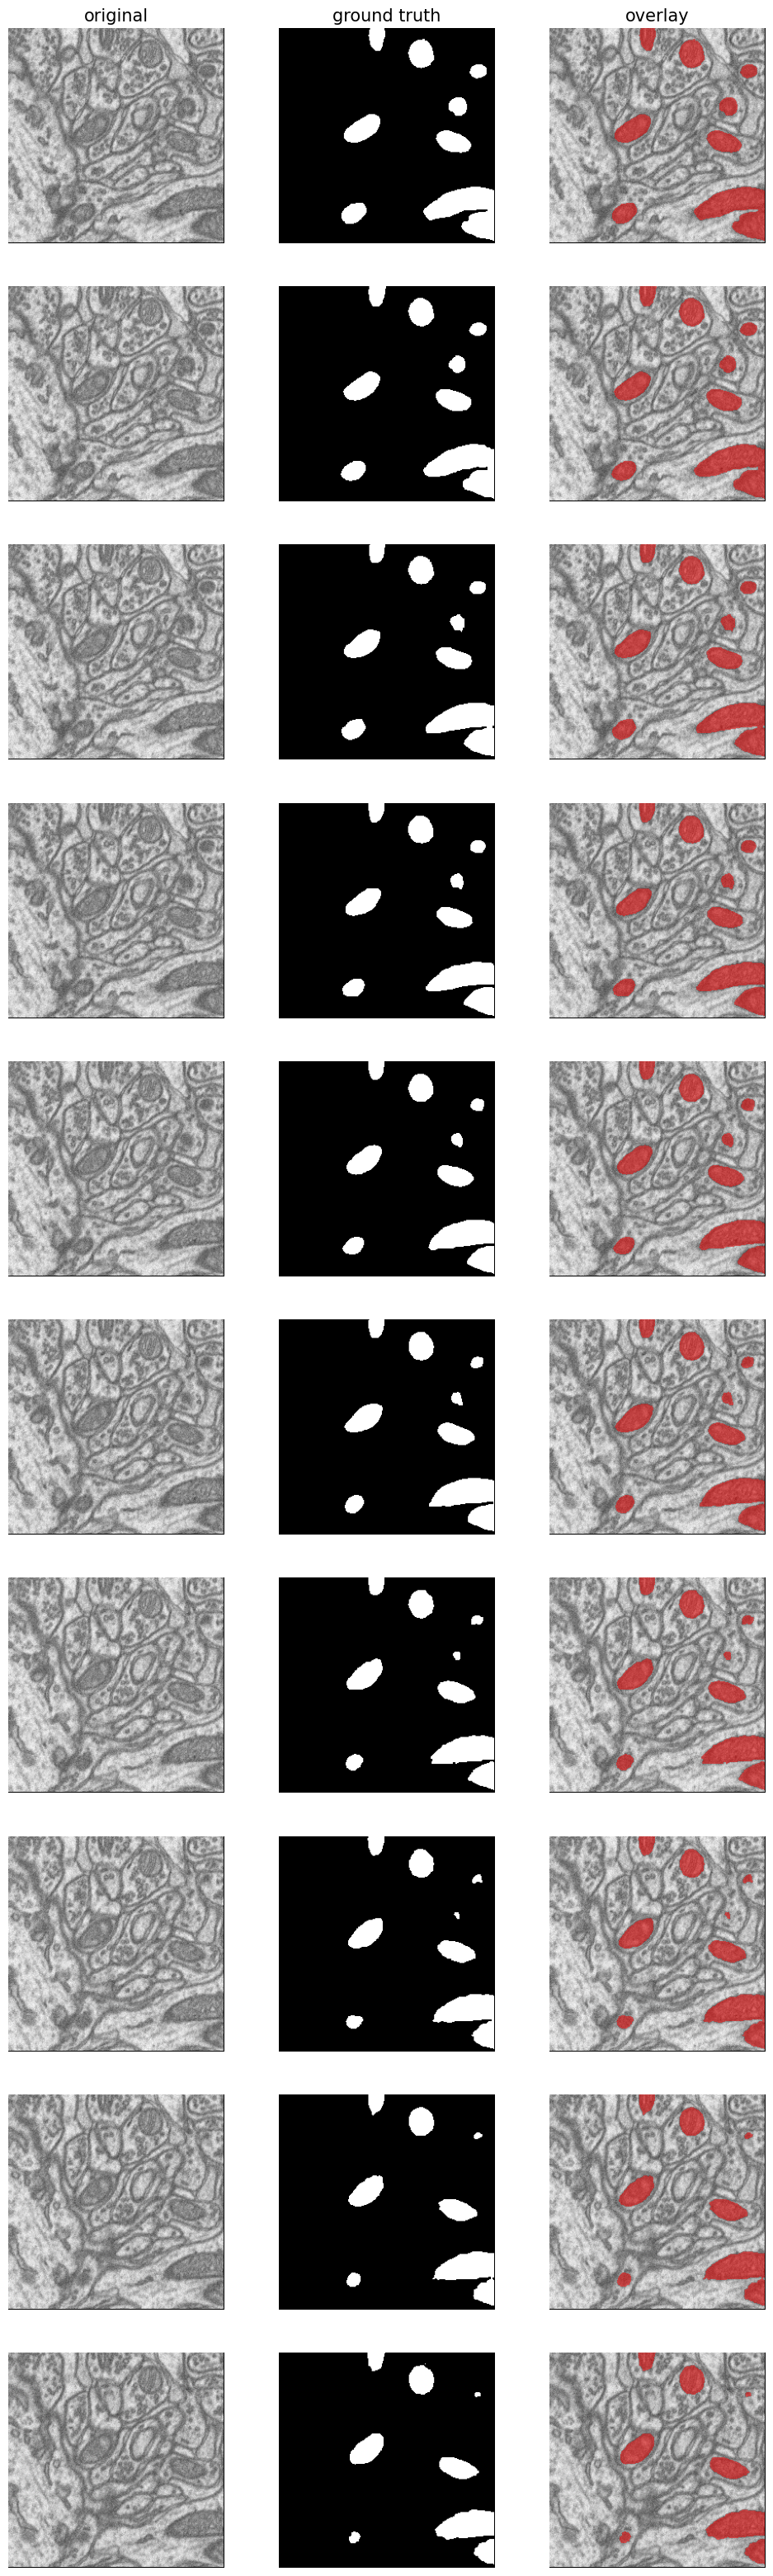

In [ ]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [ ]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
images = images.astype(np.float32) / 243.0

# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
images = images.reshape(images.shape + (1,))
#
# TODO: YOUR_CODE
X = images


In [ ]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [ ]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
masks = masks.astype(bool)

# 1) convert to bool
# 2) Add the last channel using .reshape like in class
masks = masks.reshape(masks.shape + (1,))
# TODO: YOUR_CODE
y = masks

In [ ]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [ ]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [ ]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER The first train_test_split call is used to split the original dataset into training and testing sets, where test_size is set to 0.2. This means that 20% of the original data will be allocated to the test set, and the remaining 80% of the data will be used for training.The second train_test_split call is then used to split the training set obtained from the first split into training and validation sets. This time, test_size is set to 0.3, which means that 30% of the training set will be allocated to the validation set, and the remaining 70% will be used for training.By doing this, we are able to create a training set, a validation set, and a testing set that are all independent and representative of the original dataset, which is important for evaluating the performance of the model on unseen data

In [ ]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER The get_augmented function from the keras_unet.utils module is used to create an augmented image generator for the training data.he get_augmented function takes as input the training data X_train and its corresponding ground truth segmentation masks y_train. The batch_size parameter specifies the number of images to be generated in each batch during training.
# The data_gen_args dictionary specifies various data augmentation parameters that will be used to generate augmented images on-the-fly during training. These parameters include:
# By applying these data augmentation techniques during training, the model is exposed to a greater variety of input images and is able to learn more robust features, which can improve its generalization performance on unseen data.

(2, 256, 256, 1) (2, 256, 256, 1)


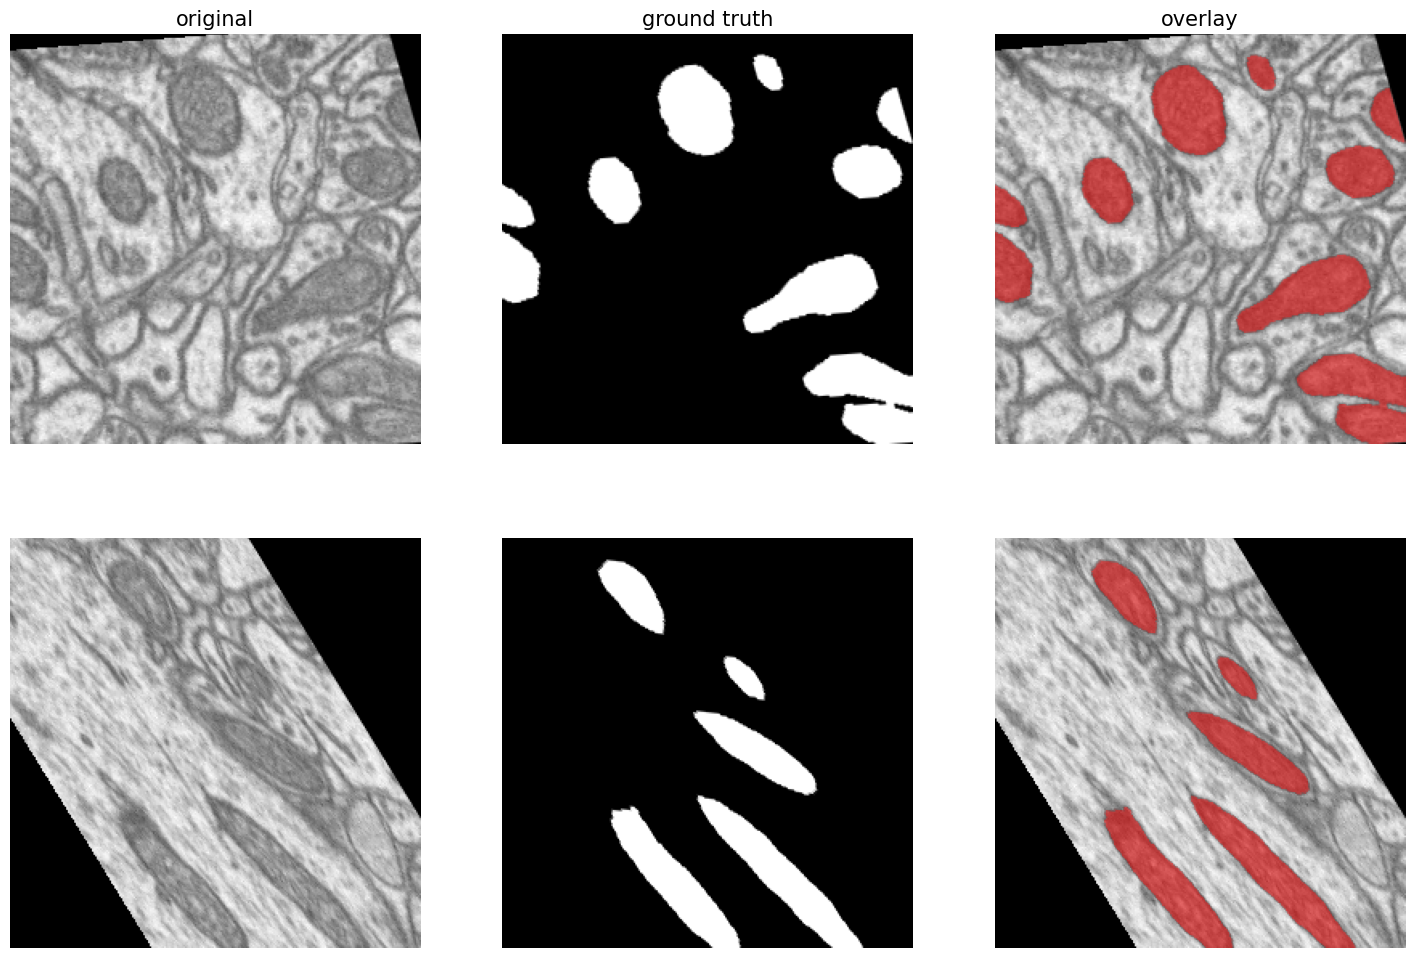

In [ ]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [ ]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [ ]:
# TODO: How many trainable parameters does the model use?
# TODO: YOUR_ANSWER
# model.summary()
# Trainable params: 31,030,593.

In [ ]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [ ]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: Intersection-over-Union (IoU) is used to evaluate image segmentation metric in computer vision tasks, particularly for image segmentation. It measures the overlap between the predicted segmentation and the ground truth segmentation of an image.
# IoU is calculated as the ratio of the intersection between the predicted and ground truth masks to the union of the two masks. 
# A higher IoU value indicates a better overlap between the predicted and ground truth segmentations. IoU ranges from 0 (no overlap) to 1 (perfect overlap).

In [ ]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history =  model.fit(
    train_gen,
    steps_per_epoch=len(X_train),
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
369/369 [==============================] - 110s 263ms/step - loss: 0.2205 - iou: 0.0711 - iou_thresholded: 0.0057 - val_loss: 0.2166 - val_iou: 0.1068 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 57s 153ms/step - loss: 0.1370 - iou: 0.2295 - iou_thresholded: 0.2186 - val_loss: 0.1327 - val_iou: 0.2953 - val_iou_thresholded: 0.5155
Epoch 3/30
369/369 [==============================] - 57s 156ms/step - loss: 0.0999 - iou: 0.3715 - iou_thresholded: 0.4747 - val_loss: 0.0877 - val_iou: 0.4352 - val_iou_thresholded: 0.6545
Epoch 4/30
369/369 [==============================] - 58s 156ms/step - loss: 0.0837 - iou: 0.4524 - iou_thresholded: 0.5568 - val_loss: 0.0862 - val_iou: 0.5448 - val_iou_thresholded: 0.6370
Epoch 5/30
369/369 [==============================] - 58s 157ms/step - loss: 0.0711 - iou: 0.5179 - iou_thresholded: 0.6293 - val_loss: 0.0553 - val_iou: 0.6354 - val_iou_thresholded: 0.7715
Epoch 6/30
369/369 [====================

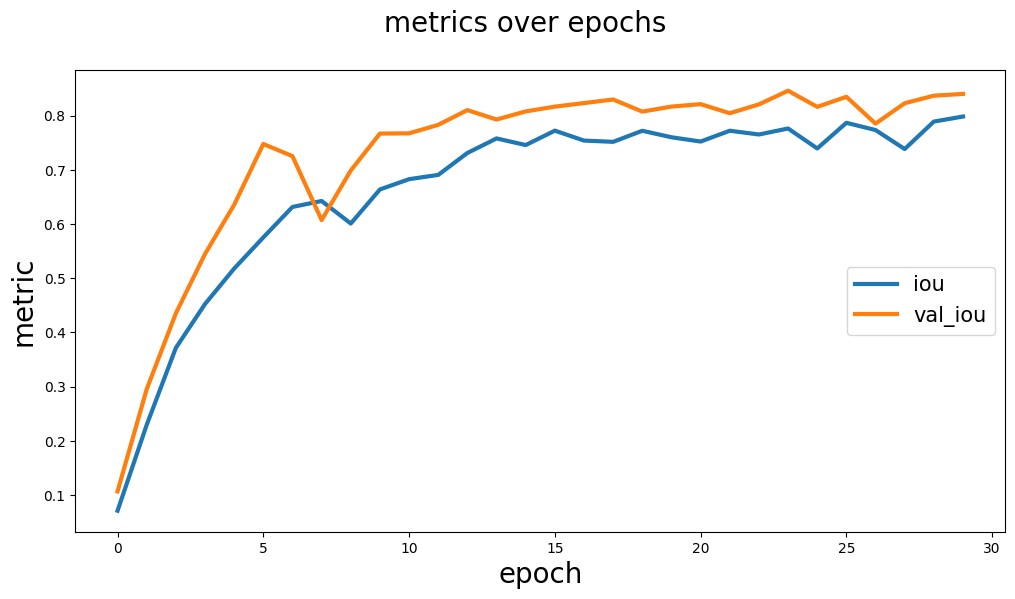

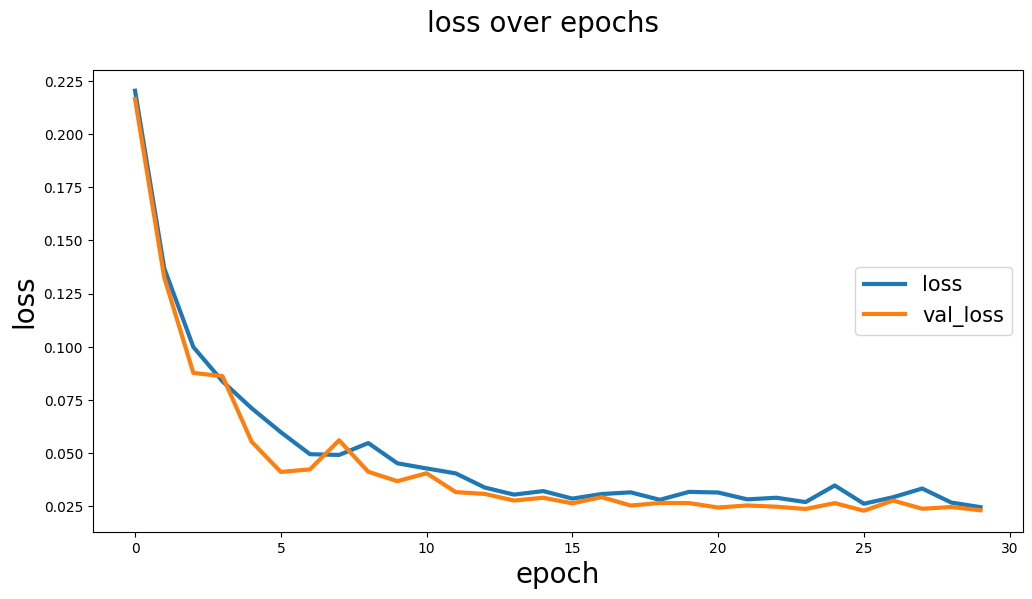

In [ ]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: Yes . They look good the metric over epoch is showing an increase in the metric overall, indicating that the model is improving in its ability to perform the specific task.
# The loss over epoch is showing a decrease in the loss overall, indicating that the model is learning and becoming more accurate.

## 3. Evaluate U-Net (10 points)

In [ ]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 4s 1s/step


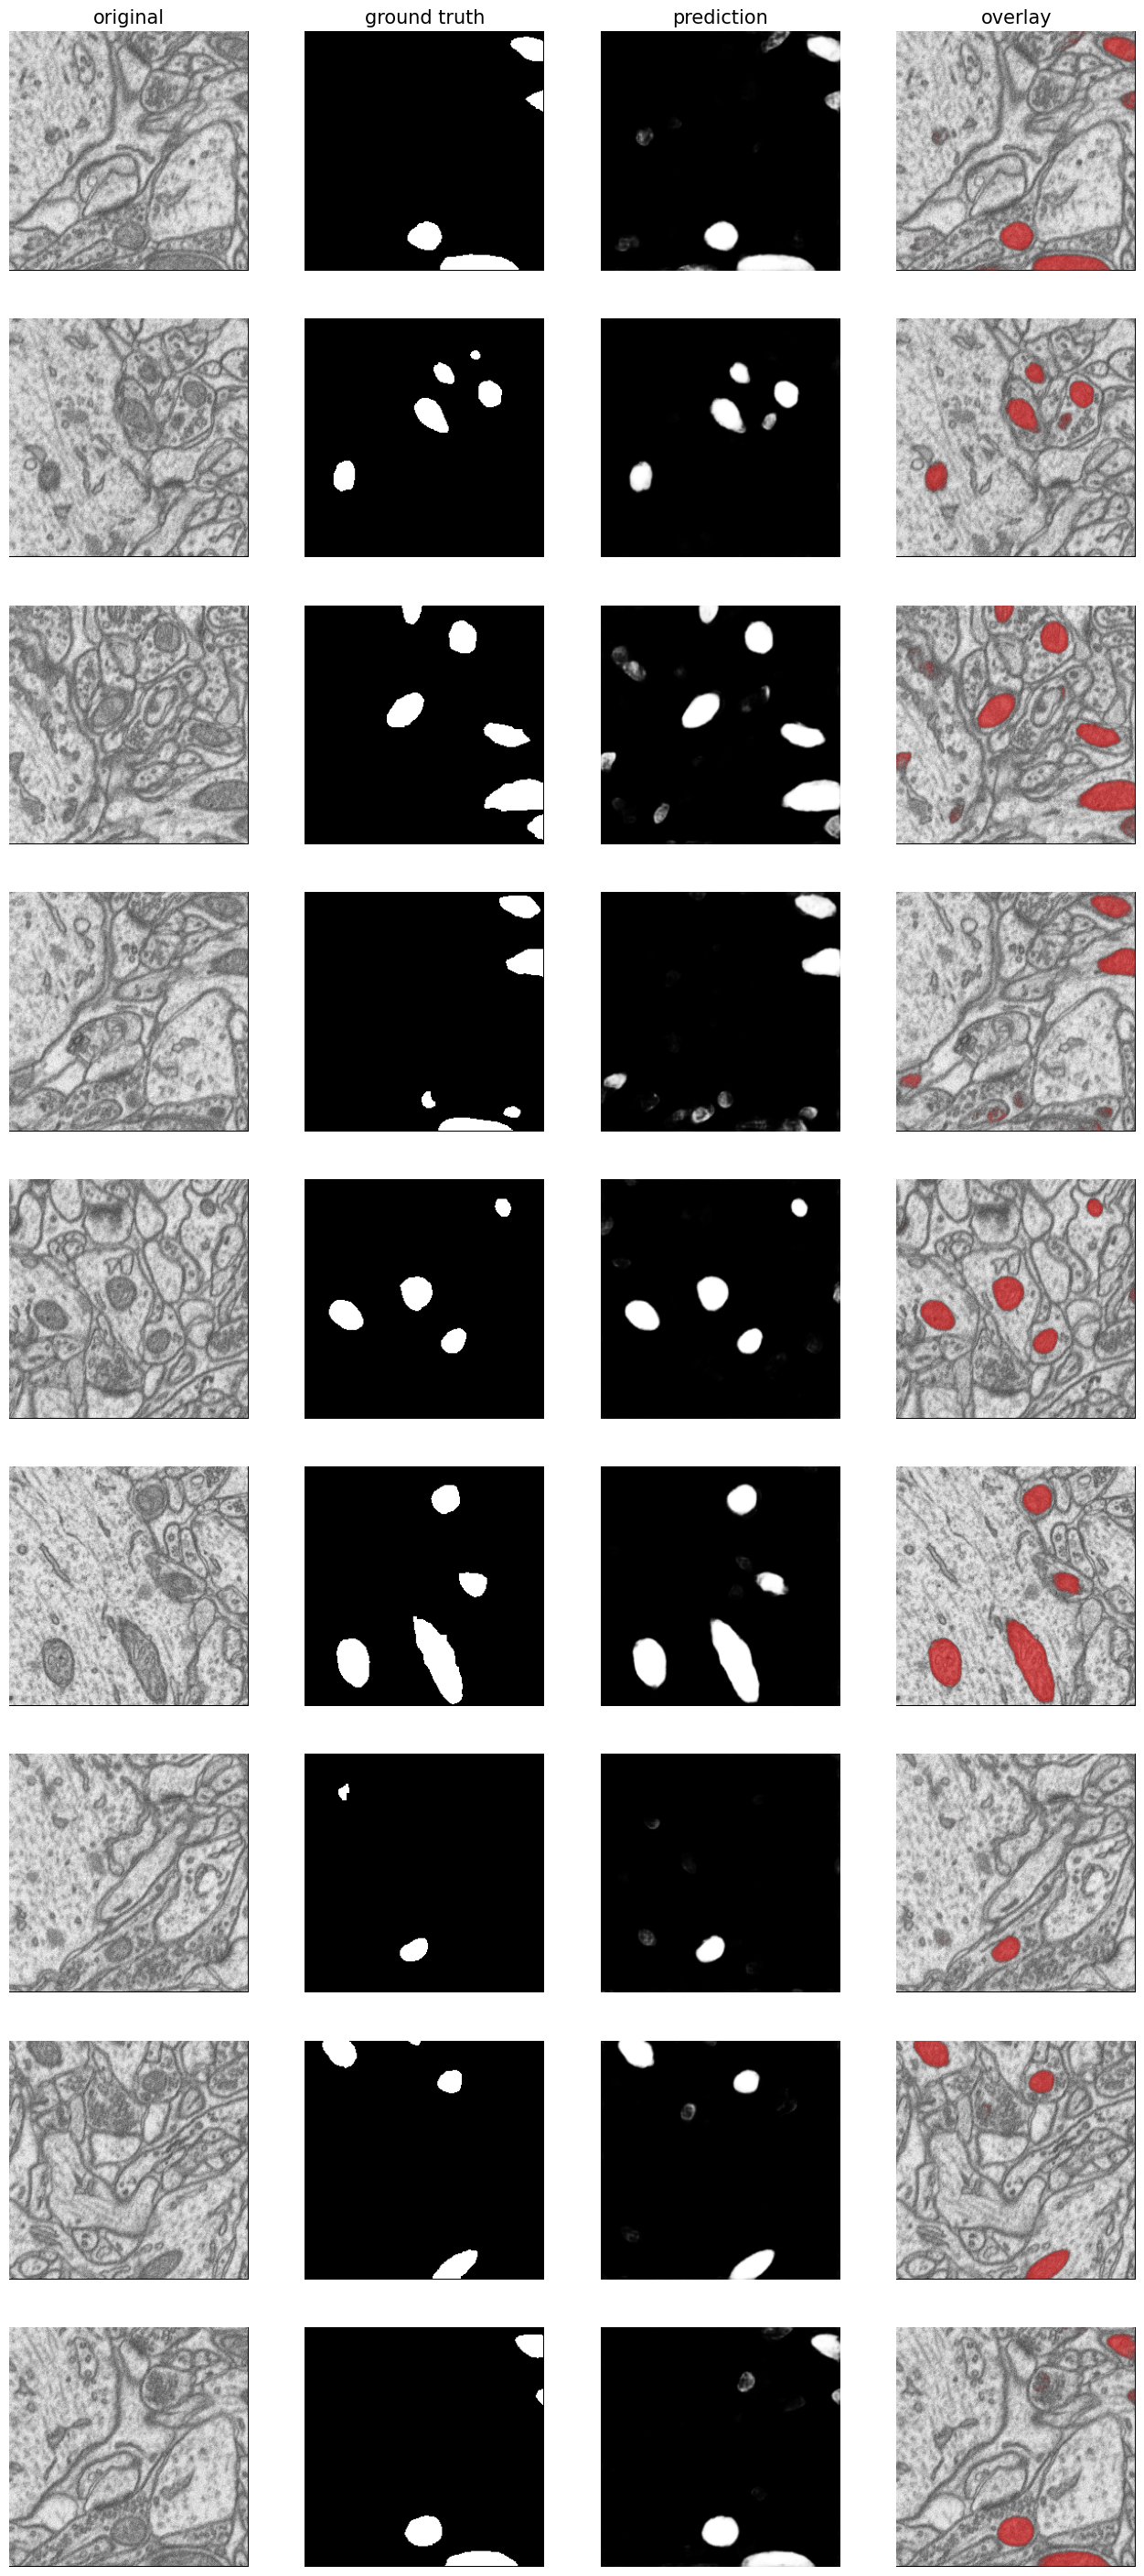

In [ ]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [ ]:
import sklearn.metrics

In [ ]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8844461762213935

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: ANS: The difference is in the denominator in the formula:
# IoU is calculated as the ratio of the intersection between the predicted segmentation mask and the ground truth segmentation mask to the union of these two masks. 
# The formula for IoU is:
# IoU = intersection of predicted mask and ground truth mask / union of predicted mask and ground truth mask.
# On the other hand, the Jaccard Score is calculated as the ratio of the intersection between the predicted segmentation mask and the ground truth segmentation mask to the sum of the areas of these two masks. 
# The formula for the Jaccard Score is:
# Jaccard Score = intersection of predicted mask and ground truth mask / (area of predicted mask + area of ground truth mask - intersection of predicted mask and ground truth mask)



In [ ]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER: To predict if the U-Net performs well on X_test, we can use various evaluation metrics such as Jaccard Score. 
# So from the above score of 0.8936604415809388 the UNET performed fairly well as it is close to 1.

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [ ]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [ ]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW: ANS: It saves the current test image as test.png
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  # ANS: 0.5 is threshold where values greater than 0.5 are considered as positive predictions and lesser negative for the current test image (y_pred[z]) to obtain a binary mask.
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  # ANS: Labels the connected components in the binary mask using the label function in mahotas.
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  #ANS : It computes the bounding boxes of the labeled connected components in the binary mask using the bbox function.
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  # ANS : It converts the bounding boxes from the Mahotas format to the SAM format using the mahotas_bbox_to_sam function.
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  # ANS : It applies the SAM model to the current test image using the image_predict function of SegManualMaskPredictor(). 
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  # ANS: It extracts the segmentation mask obtained from the SAM model by converting the output of the image_predict function to a binary mask.
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  # ANS: It stores the segmentation mask obtained from the SAM model in the corresponding channel of the y_pred_sam array for the current test image.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [ ]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8844461762213935

In [ ]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8540860861096136

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: No, From the above results it is evident that U-Net + SAM performace is lower than U-Net . If we improve the performance of U-Net + SAM by adjusting the parameters it might be a good addition. 

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
# TODO: YOUR_CODE
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [ ]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_h", 
      input_box=bbs_converted, 
      multimask_output=True,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_h model already exists as 'vit_h.pth'. Skipping download.


OutOfMemoryError: ignored

In [ ]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#